In [1]:
!python -m venv astro_env

In [2]:
!.\astro_env\Scripts\activate

In [3]:
!pip install numpy matplotlib opencv-python astropy photutils scikit-image scikit-learn tensorflow torch torchvision tqdm

   ---------------------------------------- 0.0/756.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/756.2 kB ? eta -:--:--
    --------------------------------------- 10.2/756.2 kB ? eta -:--:--
    --------------------------------------- 10.2/756.2 kB ? eta -:--:--
   - ------------------------------------- 30.7/756.2 kB 187.9 kB/s eta 0:00:04
   - ------------------------------------- 30.7/756.2 kB 187.9 kB/s eta 0:00:04
   ---- ---------------------------------- 81.9/756.2 kB 353.1 kB/s eta 0:00:02
   ----- -------------------------------- 112.6/756.2 kB 469.7 kB/s eta 0:00:02
   -------- ----------------------------- 163.8/756.2 kB 517.2 kB/s eta 0:00:02
   ------------ ------------------------- 256.0/756.2 kB 716.5 kB/s eta 0:00:01
   ---------------- --------------------- 337.9/756.2 kB 840.2 kB/s eta 0:00:01
   ---------------------- --------------- 440.3/756.2 kB 984.2 kB/s eta 0:00:01
   --------------------------- ------------ 522.2/756.2 kB 1.1 MB/s eta 0:

In [4]:
from photutils.datasets import make_100gaussians_image
import matplotlib.pyplot as plt

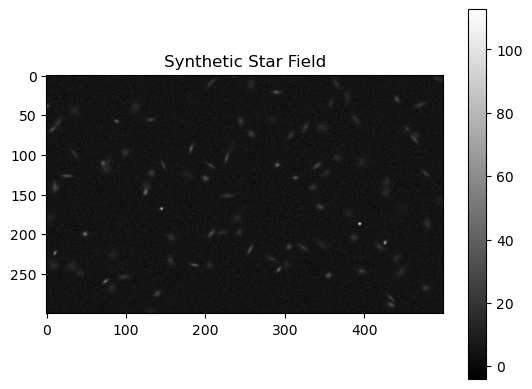

In [5]:
# Generate synthetic image with 100 Gaussian stars
image = make_100gaussians_image()
plt.imshow(image, cmap='gray')
plt.title('Synthetic Star Field')
plt.colorbar()
plt.show()


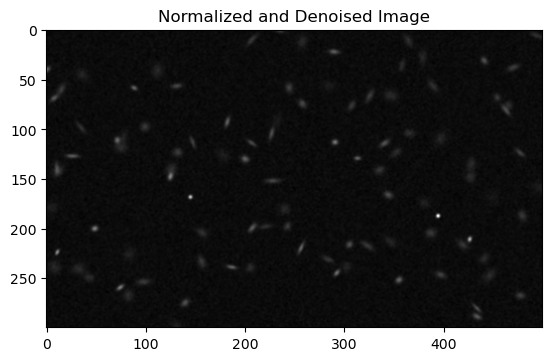

In [6]:
# Preprocess the Image

import cv2
import numpy as np

# Normalize and denoise
image = image.astype(np.float32)
image = (image - np.min(image)) / (np.max(image) - np.min(image))
image = cv2.GaussianBlur(image, (3, 3), 0)
plt.imshow(image, cmap='gray')
plt.title('Normalized and Denoised Image')
plt.show()

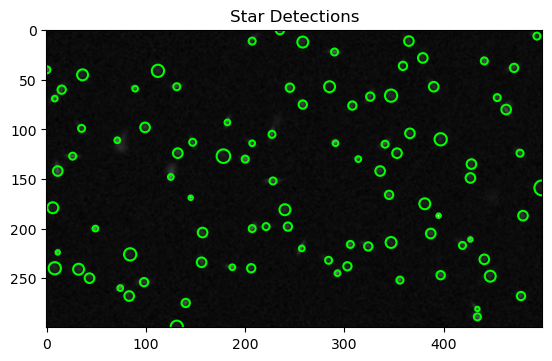

In [7]:
# Detect Stars (Blobs)

from skimage.feature import blob_log

blobs = blob_log(image, max_sigma=5, num_sigma=10, threshold=0.02)

# Visualize detections
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
for blob in blobs:
    y, x, r = blob
    c = plt.Circle((x, y), r*1.5, color='lime', linewidth=1.5, fill=False)
    ax.add_patch(c)
plt.title('Star Detections')
plt.show()

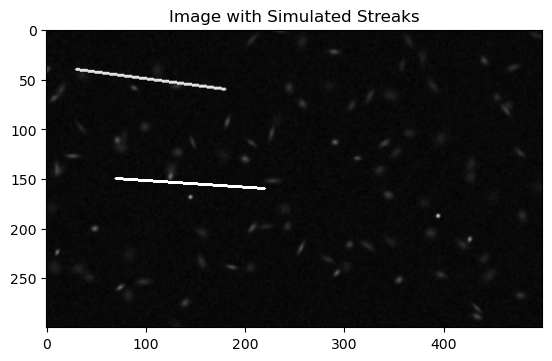

In [8]:
# Simulate Streaks (RSOs)
# Add synthetic streaks using OpenCV line drawing
image_with_streaks = image.copy()
cv2.line(image_with_streaks, (30, 40), (180, 60), 0.8, 2)
cv2.line(image_with_streaks, (70, 150), (220, 160), 0.9, 2)
plt.imshow(image_with_streaks, cmap='gray')
plt.title('Image with Simulated Streaks')
plt.show()

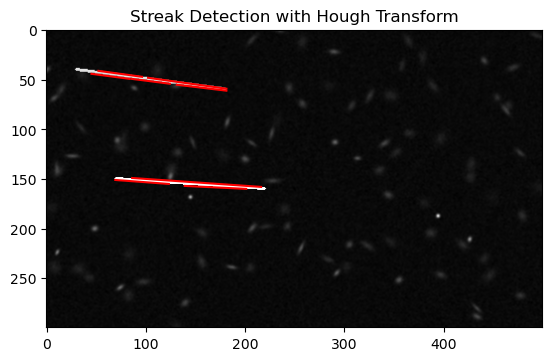

In [9]:
# Detect Streaks (Lines)

# Use Hough Transform for line detection
from skimage.transform import probabilistic_hough_line
from skimage import exposure

edges = cv2.Canny((image_with_streaks*255).astype(np.uint8), 50, 150)
lines = probabilistic_hough_line(edges, threshold=10, line_length=30, line_gap=3)

fig, ax = plt.subplots()
ax.imshow(image_with_streaks, cmap='gray')
for line in lines:
    p0, p1 = line
    ax.plot((p0[0], p1[0]), (p0[1], p1[1]), color='red')
plt.title('Streak Detection with Hough Transform')
plt.show()


In [10]:
# Classification (Blob vs. Streak)

# Use simple features like shape, length to classify
features = []
labels = []

for blob in blobs:
    y, x, r = blob
    features.append([r])  # radius as feature
    labels.append(0)  # 0 for star

for line in lines:
    p0, p1 = line
    length = np.linalg.norm(np.array(p0) - np.array(p1))
    features.append([length])
    labels.append(1)  # 1 for streak

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(features, labels)

print("Classification Accuracy:", clf.score(features, labels))

Classification Accuracy: 1.0


In [11]:
# Sub-pixel Accuracy (Gaussian Centroiding)

from scipy.ndimage import center_of_mass

# Extract small patch and find center of mass for sub-pixel centroid
patch_size = 15
for blob in blobs[:3]:  # Show for first 3 detections
    y, x, r = blob
    y, x = int(y), int(x)
    patch = image[max(0, y-patch_size):y+patch_size, max(0, x-patch_size):x+patch_size]
    cy, cx = center_of_mass(patch)
    print(f"Star at approx ({x}, {y}) has refined centroid at ({cx + x - patch_size:.2f}, {cy + y - patch_size:.2f})")

Star at approx (395, 187) has refined centroid at (394.11, 186.41)
Star at approx (145, 169) has refined centroid at (144.67, 168.46)
Star at approx (427, 211) has refined centroid at (425.90, 211.07)


In [12]:
# Orientation Estimation (Bayesian Inference Placeholder)

# Not full Bayesian implementation, but conceptually:
# Assume Gaussian distribution over possible angles based on line slopes
angles = []
for line in lines:
    p0, p1 = line
    dx = p1[0] - p0[0]
    dy = p1[1] - p0[1]
    angle = np.arctan2(dy, dx)
    angles.append(angle)

# Mean orientation (approximate MAP estimation)
mean_angle = np.mean(angles)
print(f"Estimated average orientation of detected RSOs: {np.degrees(mean_angle):.2f} degrees")

Estimated average orientation of detected RSOs: -173.96 degrees


In [14]:
# Save Results and Document

# Save annotated image
cv2.imwrite("output_with_detections.png", (image_with_streaks*255).astype(np.uint8))


True